<a href="https://colab.research.google.com/github/charlottecvn/InformationRetrieval-RU/blob/main/Pandemic_Test_Retrieval_Group_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information Retrieval - Project 

## Pandemic (covid-19) retrieval test collection

Linda Schmeitz, Enrico Schmitz, Charlotte Cambier van Nooten 


## Libraries

In [ ]:
%%capture
!pip install pyserini==0.10.0.0
#!pip install nltk

import json
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt

import gc

from pyserini.search import SimpleSearcher
from pyserini.index import IndexReader

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords') 
nltk.download('punkt') 

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

## Downloading data

In [ ]:
%%capture
!wget https://www.dropbox.com/s/dyd9sggrqo44d0n/lucene-index-cord19-full-text-2020-07-16.tar.gz
!tar xvfz lucene-index-cord19-full-text-2020-07-16.tar.gz

In [ ]:
!du -h lucene-index-cord19-full-text-2020-07-16

5.2G	lucene-index-cord19-full-text-2020-07-16


## Pre-processing

In [ ]:
topics_df = pd.read_csv('topics.csv',delimiter=';')

full_query = topics_df['query']

lower_case_query = []
for i in full_query:
    lower_case_query.append(i.lower())
print(lower_case_query)

sans_punctuation_query = []
import string

for i in lower_case_query:
    sans_punctuation_query.append(''.join(c for c in i if c not in string.punctuation))
    
print(sans_punctuation_query)

['coronavirus origin', 'coronavirus response to weather changes', 'coronavirus immunity', 'how do people die from the coronavirus', 'animal models of covid-19', 'coronavirus test rapid testing', 'serological tests for coronavirus', 'coronavirus under reporting', 'coronavirus in canada', 'coronavirus social distancing impact', 'coronavirus hospital rationing', 'coronavirus quarantine', 'how does coronavirus spread', 'coronavirus super spreaders', 'coronavirus outside body', 'how long does coronavirus survive on surfaces', 'coronavirus clinical trials', 'masks prevent coronavirus', 'what alcohol sanitizer kills coronavirus', 'coronavirus and ace inhibitors', 'coronavirus mortality', 'coronavirus heart impacts', 'coronavirus hypertension', 'coronavirus diabetes', 'coronavirus biomarkers', 'coronavirus early symptoms', 'coronavirus asymptomatic', 'coronavirus hydroxychloroquine', 'coronavirus drug repurposing', 'coronavirus remdesivir', 'difference between coronavirus and flu', 'coronaviru

In [ ]:
synom_sars = ["sars-cov-2", "coronavirus", "sarscov2", "corona"]
query_list = []

for query in sans_punctuation_query:
    query_synom = [] 
    text_tokens = word_tokenize(query)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords.words('english')]
    
    syn= None
    for word in tokens_without_sw:
      if word.lower() in synom_sars:
        syn = word.lower()
        break
    filtered_sentence = (" ").join(tokens_without_sw).lower()
    
    if syn != None:
      for syns in synom_sars:
        query_synom.append(filtered_sentence.replace(syn,syns))
    else:
      query_synom.append(filtered_sentence)
    query_list.append(query_synom)
print(query_list)

[['sars-cov-2 origin', 'coronavirus origin', 'sarscov2 origin', 'corona origin'], ['sars-cov-2 response weather changes', 'coronavirus response weather changes', 'sarscov2 response weather changes', 'corona response weather changes'], ['sars-cov-2 immunity', 'coronavirus immunity', 'sarscov2 immunity', 'corona immunity'], ['people die sars-cov-2', 'people die coronavirus', 'people die sarscov2', 'people die corona'], ['animal models covid19'], ['sars-cov-2 test rapid testing', 'coronavirus test rapid testing', 'sarscov2 test rapid testing', 'corona test rapid testing'], ['serological tests sars-cov-2', 'serological tests coronavirus', 'serological tests sarscov2', 'serological tests corona'], ['sars-cov-2 reporting', 'coronavirus reporting', 'sarscov2 reporting', 'corona reporting'], ['sars-cov-2 canada', 'coronavirus canada', 'sarscov2 canada', 'corona canada'], ['sars-cov-2 social distancing impact', 'coronavirus social distancing impact', 'sarscov2 social distancing impact', 'corona

## Indexing (pre-build)

In [ ]:
index_reader = IndexReader('lucene-index-cord19-full-text-2020-07-16/')
print(index_reader.stats())

{'total_terms': 275238847, 'documents': 192460, 'non_empty_documents': 192460, 'unique_terms': 1843368}


## Ranking (own model)

### BM25 ranking function

In [ ]:
def ranking_bm25 (index_reader, term):
  analyzed = index_reader.analyze(term)

  docids_df =  pd.read_table('docids.txt', header=None)
  docids_df = ((np.array(docids_df)).flatten())

  query = term

  doc_scores = []

  doc_scores.append(
      {
          'doc_id': '0',
          'score': 0
      }
  )

  # Score determineted with the query document score
  for i in range(0, len(docids_df)):
    score = index_reader.compute_query_document_score(docids_df[i], query)
    if score >= 0.0:
      doc_scores.append(
          {
              'doc_id': docids_df[i],
              'score': score
          }
      ) 

  # Return the top-10 documents
  doc_scores_df = pd.DataFrame(doc_scores)
  result = doc_scores_df.sort_values(by=['score'],ascending=False)
  return result#[:10]

### Apply ranking for all the queries

In [ ]:
qrels_df = pd.read_table('qrels.txt', sep=",")
qrels_df.rename(columns={'topic-id': 'topic_ids', 'cord-id': 'doc_ids'}, inplace=True)


In [ ]:
keys = ['ranks','doc_ids','scores','queries', 'topic_ids',  'judgement']
data_ranking_all = {key: [] for key in keys}

for j, queries in enumerate(query_list): 
  print(queries)

  df_scores = pd.DataFrame(columns=keys)

  for i,query in enumerate(queries):
    df_scores_i = pd.DataFrame(columns=['doc_ids','scores','queries', 'topic_ids'])
    rank_df = ranking_bm25 (index_reader, query)
    rank_df = rank_df.reset_index(drop=True)

    df_scores_i['doc_ids'] = rank_df['doc_id'].values
    df_scores_i['scores'] = rank_df['score'].values
    df_scores_i['queries'] = ([query] * len(rank_df['doc_id'].values))
    df_scores_i['topic_ids'] = ([j+1] * len(rank_df['doc_id'].values))

    # filter on topics and doc ids that match with the qrels
    merged_qrels = pd.merge(df_scores_i, qrels_df, how='inner',on=['doc_ids','topic_ids']) #pd.merge(df_scores_i, qrels_df,how='inner', left_on=['doc_ids','topic_ids'], right_on=[' cord-id','topic-id']) 
    df_scores = df_scores.append(merged_qrels)

  result_topk = df_scores.sort_values(by=['scores'],ascending=False, ignore_index=True)
  result_topk_drop = result_topk.drop_duplicates(subset = ['doc_ids'])
  df_scores = result_topk_drop#[:10]  
  df_scores.loc[:,'ranks'] = range(1,len(result_topk_drop['scores'])+1)
  
  for key in data_ranking_all.keys():
    data_ranking_all[key].extend(df_scores[key])

df_ranking_all = pd.DataFrame(data_ranking_all)
print(df_ranking_all)

df_ranking_all.to_csv('ranking_term_queries_bm25.csv')  

['sars-cov-2 origin', 'coronavirus origin', 'sarscov2 origin', 'corona origin']


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


['sars-cov-2 response weather changes', 'coronavirus response weather changes', 'sarscov2 response weather changes', 'corona response weather changes']
['sars-cov-2 immunity', 'coronavirus immunity', 'sarscov2 immunity', 'corona immunity']
['people die sars-cov-2', 'people die coronavirus', 'people die sarscov2', 'people die corona']
['animal models covid19']
['sars-cov-2 test rapid testing', 'coronavirus test rapid testing', 'sarscov2 test rapid testing', 'corona test rapid testing']
['serological tests sars-cov-2', 'serological tests coronavirus', 'serological tests sarscov2', 'serological tests corona']
['sars-cov-2 reporting', 'coronavirus reporting', 'sarscov2 reporting', 'corona reporting']
['sars-cov-2 canada', 'coronavirus canada', 'sarscov2 canada', 'corona canada']
['sars-cov-2 social distancing impact', 'coronavirus social distancing impact', 'sarscov2 social distancing impact', 'corona social distancing impact']
['sars-cov-2 hospital rationing', 'coronavirus hospital ration

In [ ]:
#df_ranking_all = pd.read_csv("ranking_term_queries_bm25.csv")
#df_ranking_all

## Ranking with the use of Lucene (anserini)

In [ ]:
searcher = SimpleSearcher('lucene-index-cord19-full-text-2020-07-16/')
topics = topics_df['query']

In [34]:
docids_df =  pd.read_table('docids.txt', header=None)
docids_df = ((np.array(docids_df)).flatten())

def custom_search(searcher, topics, feedback="BM25", amount_ranks =len(docids_df)):
  # relevance feedback: bm25, rm3 (pseudo), qld (dirichlet)
  if feedback.upper()=="QLD":
    searcher.set_qld(mu=1000)
  elif feedback.upper()=="RM3": #combination (reranking)
    searcher.set_bm25(k1=float(0.9), b=float(0.4))
    searcher.set_rm3(fb_terms=10, fb_docs=10, original_query_weight=float(0.5), rm3_output_query=False)
  elif feedback.upper()=="BM25":
    searcher.unset_rm3()
    searcher.set_bm25(k1=float(0.9), b=float(0.4))
  else:
    print("Relevance feedback method is not defined, default is set to BM25")
    searcher.unset_rm3()
    searcher.set_bm25(k1=float(0.9), b=float(0.4))

  # searcher
  hits = {}

  # bag of words
  keys = ['ranks','doc_ids','scores','topics_rep', 'topic_ids']
  data = {key: [] for key in keys}

  for i,topic in enumerate(topics):
    gc.collect()
    hits_i = searcher.search(topic, amount_ranks)
    hits[topic] = [hits_i,[]]

    topics_rep = [topic]*len(docids_df)
    topic_ids = [i+1]*len(docids_df)
    ranks = list(range(1,len(docids_df)+1)) 

    doc_ids = []
    scores = []
    for hit in hits[topic][0]:
      if (hit.docid in docids_df):
        if (hit.docid not in doc_ids):
          doc_ids.append(hit.docid)
          scores.append(hit.score)

    not_ranked_docs = set(docids_df)-set(doc_ids)
    doc_ids.extend(not_ranked_docs)

    not_ranked_scores = [0.0]*len(not_ranked_docs)
    scores.extend(not_ranked_scores)

    for key in data.keys():
        data[key].extend(eval(key))

  df = pd.DataFrame(data)

  return df


Custom searcher will retrieve hits for top-100 ranking, due to memory issues rest of scores will be set to 0.0. Resulting in dataframe with all docids.

### BM25

In [ ]:
df_bm25 = custom_search(searcher, topics, feedback="bm25", amount_ranks=100)
merged_qrels_bm25 = pd.merge(df_bm25, qrels_df, how='inner',on=['doc_ids','topic_ids'])

df_bm25.to_csv('ranking_term_queries_bm25_lucene.csv')
merged_qrels_bm25.to_csv('judged_queries_bm25_lucene.csv')

### RM3

In [35]:
df_rm3 = custom_search(searcher, topics, feedback="rm3", amount_ranks=100)
merged_qrels_rm3 = pd.merge(df_rm3, qrels_df, how='inner',on=['doc_ids','topic_ids'])

df_rm3.to_csv('ranking_term_queries_rm3_lucene.csv')
merged_qrels_rm3.to_csv('judged_queries_rm3_lucene.csv')

<org.apache.lucene.search.similarities.Similarity at 0x7fa6cc3c3990 jclass=org/apache/lucene/search/similarities/Similarity jself=<LocalRef obj=0x61bc800 at 0x7fa6d04d8fd0>>


## Evaluation

In [36]:
def evaluation(df, topic_id, judgement_param = 1, qrels_df = qrels_df):
  qrels_df = qrels_df[qrels_df["topic_ids"] == topic_id]
  avg_precision = sum(df['judgement']>=judgement_param)/len(df['judgement'])
  recall = sum(df['judgement']>=judgement_param)/sum(qrels_df['judgement']>=judgement_param)
  return avg_precision, recall


In [37]:
max_threshold = 100
np_precision = np.zeros(shape=(max_threshold,50,3))
np_recall = np.zeros(shape=(max_threshold,50,3))

for threshold in range(0,max_threshold):
  for i, topic in enumerate(topics):
    topk_df = df_ranking_all[df_ranking_all["topic_ids"] == i+1][:threshold+1]
    topk_df_bm25 = merged_qrels_bm25[merged_qrels_bm25["topic_ids"] == i+1][:threshold+1]
    topk_df_rm3 = merged_qrels_rm3[merged_qrels_rm3["topic_ids"] == i+1][:threshold+1]
    
    p, r = evaluation(topk_df, i+1)
    p_bm25, r_bm25 = evaluation(topk_df_bm25, i+1)
    p_rm3, r_rm3 = evaluation(topk_df_rm3, i+1)

    np_precision[threshold, i, 0] = p
    np_precision[threshold, i, 1] = p_bm25
    np_precision[threshold, i, 2] = p_rm3
    np_recall[threshold, i, 0] = r
    np_recall[threshold, i, 1] = r_bm25
    np_recall[threshold, i, 2] = r_rm3

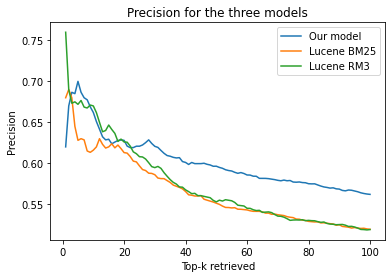

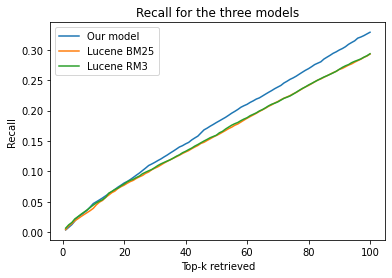

In [38]:
plt.plot(range(1,max_threshold+1), np.mean(np_precision, axis=1)[:,0], label="Our model")
plt.plot(range(1,max_threshold+1), np.mean(np_precision, axis=1)[:,1], label="Lucene BM25")
plt.plot(range(1,max_threshold+1), np.mean(np_precision, axis=1)[:,2], label="Lucene RM3")
plt.legend()
plt.xlabel("Top-k retrieved")
plt.ylabel("Precision")
plt.title("Precision for the three models")
plt.show()

plt.plot(range(1,max_threshold+1), np.mean(np_recall, axis=1)[:,0], label="Our model")
plt.plot(range(1,max_threshold+1), np.mean(np_recall, axis=1)[:,1], label="Lucene BM25")
plt.plot(range(1,max_threshold+1), np.mean(np_recall, axis=1)[:,2], label="Lucene RM3")
plt.legend()
plt.xlabel("Top-k retrieved")
plt.ylabel("Recall")
plt.title("Recall for the three models")
plt.show()

In [54]:
(np.mean(np_precision, axis=1)[:,0][-1]-np.mean(np_precision, axis=1)[:,2][-1])*100

4.299999999999993

In [48]:
diffs_ranks = np.zeros(shape=(3,3))
diffs_ranks

topk = 10

for i, topic in enumerate(topics):
  diffs_ranks[0,1] += len(set(df_ranking_all[df_ranking_all["topic_ids"]==i][:topk]["doc_ids"]).intersection(set(df_bm25[df_bm25["topic_ids"]==i][:topk]["doc_ids"])))
  diffs_ranks[1,0] = diffs_ranks[0,1] 

  diffs_ranks[0,2] += len(set(df_ranking_all[df_ranking_all["topic_ids"]==i][:topk]["doc_ids"]).intersection(set(df_rm3[df_rm3["topic_ids"]==i][:topk]["doc_ids"])))
  diffs_ranks[2,0] = diffs_ranks[0,2] 

  diffs_ranks[1,2] += len(set(df_bm25[df_bm25["topic_ids"]==i][:topk]["doc_ids"]).intersection(set(df_rm3[df_rm3["topic_ids"]==i][:topk]["doc_ids"])))
  diffs_ranks[2,1] = diffs_ranks[1,2] 

# Diagonal, 500 of 500 (50 topics times top-k)
diffs_ranks[0,0] = 50*topk
diffs_ranks[1,1] = 50*topk
diffs_ranks[2,2] = 50*topk

diffs_ranks = diffs_ranks/(50*topk) #percentage
diffs_ranks


array([[1.   , 0.134, 0.096],
       [0.134, 1.   , 0.332],
       [0.096, 0.332, 1.   ]])